In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from bart_playground import *

In [3]:
notebook = "real1_Abalone_depth"

In [4]:
import numpy as np

from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
abalone = fetch_ucirepo(id=1) 
  
# data (as pandas dataframes) 
X = abalone.data.features 
y = abalone.data.targets 
X = X.drop(columns=['Sex'])

X = X.values.astype(float)
y = np.array(y).reshape(-1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [5]:
default_proposal_probs = {"grow": 0.25, "prune": 0.25, "change": 0.4, "swap": 0.1}
bart_default = DefaultBART(ndpost=2000, nskip=0, n_trees=100, proposal_probs=default_proposal_probs)
bart_default.fit(X_train, y_train)

Iterations: 100%|██████████| 2000/2000 [00:44<00:00, 44.85it/s]


In [6]:
proposal_probs = {"multi_grow": 0.25, "multi_prune": 0.25, "multi_change": 0.4, "multi_swap": 0.1}
bart_mtmh = MultiBART(ndpost=2000, nskip=0, n_trees=100, proposal_probs=proposal_probs, multi_tries=10)
bart_mtmh.fit(X_train, y_train)

Iterations: 100%|██████████| 2000/2000 [03:56<00:00,  8.45it/s]


In [7]:
import pickle

with open(f"store/{notebook}_default_trace.pkl", "wb") as f:
    pickle.dump(bart_default.sampler.trace, f)

with open(f"store/{notebook}_mtmh_trace.pkl", "wb") as f:
    pickle.dump(bart_mtmh.sampler.trace, f)

In [8]:
# Open the pickle file
import pickle

with open(f"store/{notebook}_default_trace.pkl", "rb") as f:
    default_trace = pickle.load(f)

with open(f"store/{notebook}_mtmh_trace.pkl", "rb") as f:
    mtmh_trace = pickle.load(f)

In [9]:
import numpy as np

def count_leaves_in_trees(trace_record):
    """Count leaves (vars == -1) in all trees of a single trace record and return average"""
    total_leaves = 0
    total_trees = len(trace_record.trees)
    
    for tree in trace_record.trees:
        # Count number of -1s in vars (leaf nodes)
        leaves_count = np.sum(np.array(tree.vars) == -1)
        total_leaves += leaves_count
    
    # Return average number of leaves per tree
    return total_leaves / total_trees

# Collect average leaves for each trace record in default trace
default_avg_leaves = []
for i, trace_record in enumerate(default_trace):
    avg_leaves = count_leaves_in_trees(trace_record)
    default_avg_leaves.append(avg_leaves)

# Collect average leaves for each trace record in mtmh trace
mtmh_avg_leaves = []
for i, trace_record in enumerate(mtmh_trace):
    avg_leaves = count_leaves_in_trees(trace_record)
    mtmh_avg_leaves.append(avg_leaves)

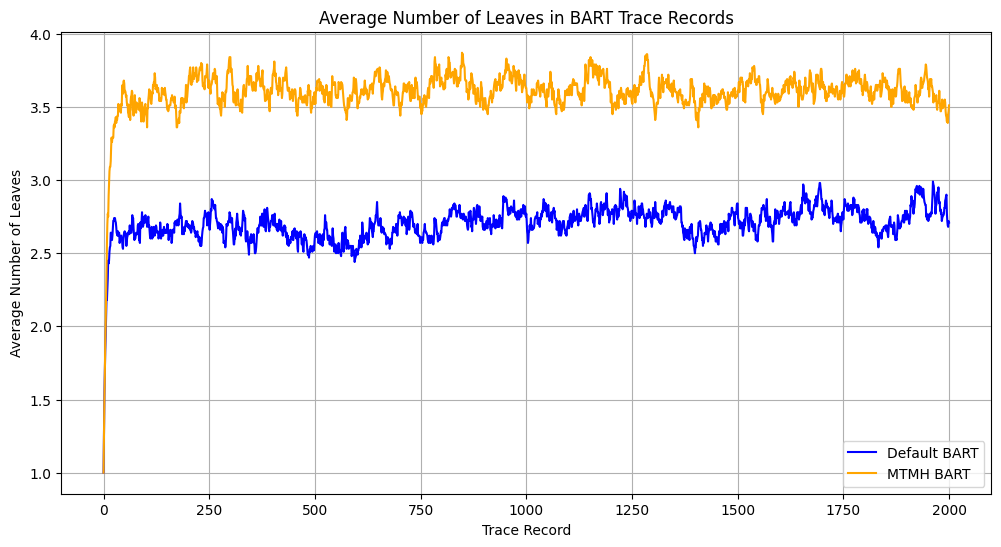

In [10]:
# Plot default_avg_leaves and mtmh_avg_leaves
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(default_avg_leaves, label='Default BART', color='blue')
plt.plot(mtmh_avg_leaves, label='MTMH BART', color='orange')
plt.xlabel('Trace Record')
plt.ylabel('Average Number of Leaves')
plt.title('Average Number of Leaves in BART Trace Records')
plt.legend()
plt.grid()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_tree_depth(tree):
    """Calculate tree depth as ceil(log2(position_of_last_-1)) - 1"""
    vars_array = np.array(tree.vars)
    
    # Find positions of all -1s (leaf nodes)
    leaf_positions = np.where(vars_array == -1)[0]
    
    # Get the last position of -1
    last_leaf_position = leaf_positions[-1]
    
    # Calculate depth
    depth = int(np.ceil(np.log2(last_leaf_position + 2))) - 1
    
    return depth

def calculate_avg_depth_per_trace(trace_record):
    """Calculate average tree depth for all trees in a trace record"""
    total_depth = 0
    total_trees = len(trace_record.trees)
    
    for tree in trace_record.trees:
        tree_depth = calculate_tree_depth(tree)
        total_depth += tree_depth
    
    return total_depth / total_trees

# Calculate average depth for each trace record in default trace
default_avg_depths = []
for i, trace_record in enumerate(default_trace):
    avg_depth = calculate_avg_depth_per_trace(trace_record)
    default_avg_depths.append(avg_depth)

# Calculate average depth for each trace record in mtmh trace
mtmh_avg_depths = []
for i, trace_record in enumerate(mtmh_trace):
    avg_depth = calculate_avg_depth_per_trace(trace_record)
    mtmh_avg_depths.append(avg_depth)

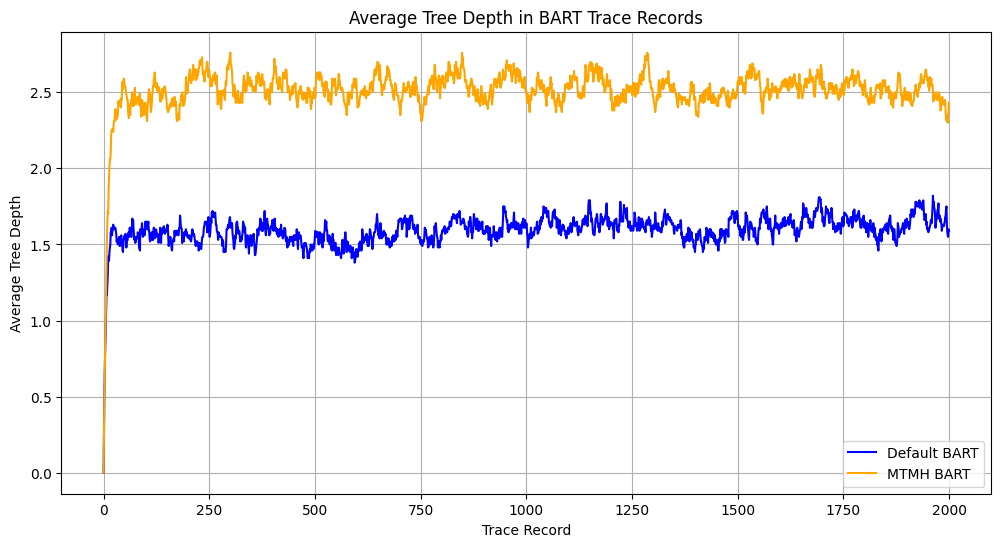

In [12]:
# Plot the average tree depths over trace records
plt.figure(figsize=(12, 6))
plt.plot(default_avg_depths, label='Default BART', color='blue')
plt.plot(mtmh_avg_depths, label='MTMH BART', color='orange')
plt.xlabel('Trace Record')
plt.ylabel('Average Tree Depth')
plt.title('Average Tree Depth in BART Trace Records')
plt.legend()
plt.grid()
plt.show()